<a href="https://colab.research.google.com/github/raita0100/transfer_learning/blob/master/pnemoniya_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pneumonia detection based on chest-xray images



* Importing the libraries 

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import os, sys, math, json
import tensorflow as tf
import cv2
from keras.preprocessing.image import ImageDataGenerator

print("Tensorflow version " + tf.__version__)
tf.enable_eager_execution()
AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 1.14.0


Using TensorFlow backend.


* getting drive access

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


* ### specifying the data directory

In [3]:
# setting data path data seperated by class name
training_dir = r"drive/My Drive/co_labs_works/chest_xray/train"
testing_dir = r"drive/My Drive/co_labs_works/chest_xray/test"
validation_dir = r"drive/My Drive/co_labs_works/chest_xray/val"

# setting output directory
model_dir =  r"drive/My Drive/co_labs_works/models"
log_dir = r"ldrive/My Drive/co_labs_works/ogs"


model_file = "drive/My Drive/co_labs_works/models/v3_weights.hdf5"
model_file

'drive/My Drive/co_labs_works/models/v3_weights.hdf5'

In [0]:
#getting files
main_dir = r"chest_xray"
test_dir = r"test"
train_dir = r"train"
val_dir = r"val"
norm = r"NORMAL"
pne = r"PNEUMONIA"

In [5]:
#read all files names and store in the data frame

#loading test data
x_test_nor = training_dir+"/"+norm+"/"
x = os.listdir(x_test_nor)
data = {'NAMES':[], 'CLASS':[]}
for i in range(0,len(x)):
    data['NAMES'].append(x_test_nor+x[i])
    data['CLASS'].append(0)
x_test_pn = training_dir+"/"+pne+"/"
x = os.listdir(x_test_pn)
for i in range(0,len(x)):
    data['NAMES'].append(x_test_pn+x[i])
    data['CLASS'].append(1)

df_test = pd.DataFrame(data)
df_test.head()

,NAMES,CLASS
0,drive/My Drive/co_labs_works/chest_xray/train/...,0
1,drive/My Drive/co_labs_works/chest_xray/train/...,0
2,drive/My Drive/co_labs_works/chest_xray/train/...,0
3,drive/My Drive/co_labs_works/chest_xray/train/...,0
4,drive/My Drive/co_labs_works/chest_xray/train/...,0


In [0]:
#shuffling the data
df_test = df_test.sample(frac=1).reset_index(drop=True)

In [0]:
#visualizing the data
def dataset_to_numpy_util(dataset, N):
    dataset = dataset[:N].values.tolist()
    numpy_images = []
    numpy_labels = []
    if tf.executing_eagerly():
        # In eager mode, iterate in the Datset directly.
        for images, labels in dataset:
            im = cv2.imread(images, 1)
            numpy_images.append(im)
            numpy_labels.append(labels)
    else: # In non-eager mode, must get the TF note that 
        # yields the nextitem and run it in a tf.Session.
        get_next_item = dataset.make_one_shot_iterator().get_next()
        with tf.Session() as ses:
            numpy_images, numpy_labels = ses.run(get_next_item)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1
  
def display_9_images_from_dataset(dataset):
    subplot=331
    plt.figure(figsize=(13,13))
    images, labels = dataset_to_numpy_util(dataset, 9)
    for i, image in enumerate(images):
        title = labels[i]
        subplot = display_one_flower(image, title, subplot)
        if i >= 8:
            break;
              
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()
    
def display_9_images_with_predictions(images, predictions, labels):
    subplot=331
    plt.figure(figsize=(13,13))
    classes = np.argmax(predictions, axis=-1)
    for i, image in enumerate(images):
        title, correct = title_from_label_and_target(classes[i], labels[i])
        subplot = display_one_flower(image, title, subplot, not correct)
        if i >= 8:
            break;
              
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()
    
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

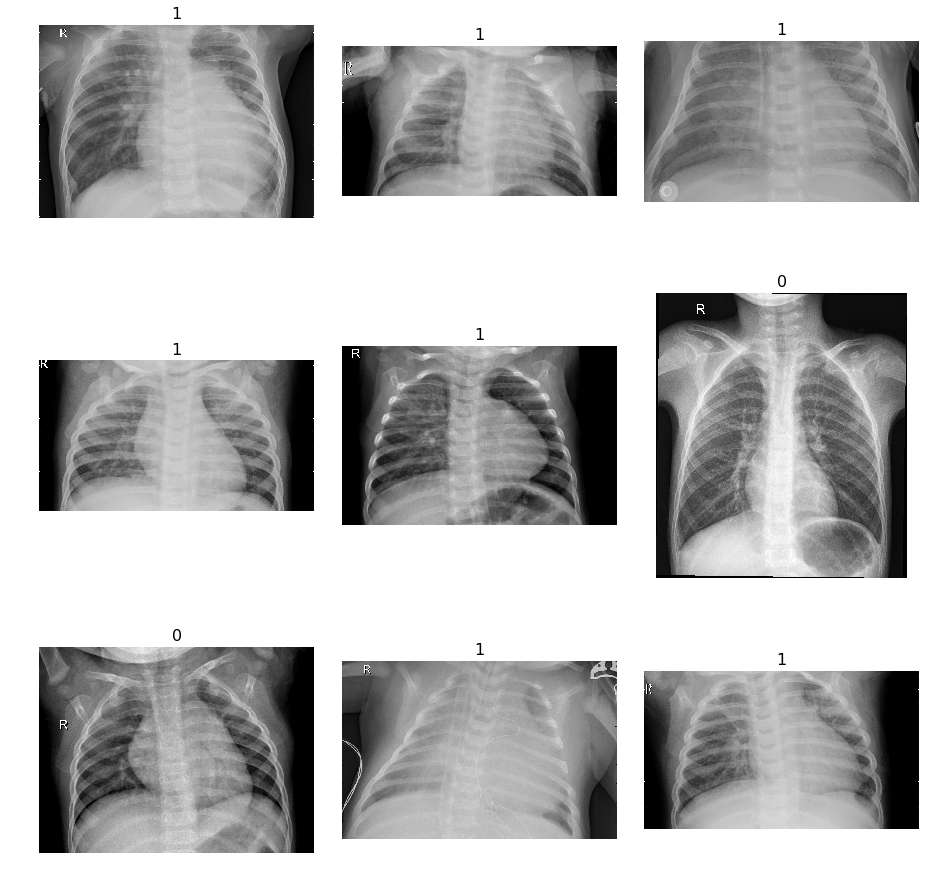

In [8]:
display_9_images_from_dataset(df_test)

* 0 --> normal
* 1 --> affected

In [0]:
# Set number of class
num_class = 2


# setting training parameters
norm = 255.0
rescale=1./norm
shear_range=0.2
zoom_range=0.2
horizontal_flip=True

# setting train, test, validation parameters
target_size=(224, 224)
batch_size=32
#batch_size=64
class_mode='binary'

loss='categorical_crossentropy'
# metrics=['accuracy', 'binary_accuracy', precision, recall]
metrics=['accuracy']

epochs = 100
verbose = 1

In [10]:

# data generator for training
train_datagen = ImageDataGenerator(rescale=rescale)

train_generator = train_datagen.flow_from_directory(
        training_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode)

# data generator for validation
validation_datagen = ImageDataGenerator(rescale=rescale)
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode)

# data generator for testing
test_datagen = ImageDataGenerator(rescale=rescale)
test_generator = test_datagen.flow_from_directory(
        testing_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode)



Found 5228 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [11]:
pretrained_model = tf.keras.applications.inception_v3.InceptionV3(weights='imagenet', input_shape=(224, 224, 3), include_top=False)
#pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
#pretrained_model.trainable = False

### QUESTION 1.
model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dense (Dense)                (None, 2)                 102402    
Total params: 21,905,186
Trainable params: 21,870,754
Non-trainable params: 34,432
_________________________________________________________________


In [12]:
history = model.fit(
    train_generator,
    steps_per_epoch=50,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=16
    )

Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
50/50 [==============================] - 582s 12s/step - loss: 0.3567 - acc: 0.9171 - val_loss: 4.8105 - val_acc: 0.3750
Epoch 2/10
50/50 [==============================] - 568s 11s/step - loss: 0.1092 - acc: 0.9606 - val_loss: 0.4368 - val_acc: 0.7500
Epoch 3/10
50/50 [==============================] - 565s 11s/step - loss: 0.1106 - acc: 0.9613 - val_loss: 4.3458 - val_acc: 0.5000
Epoch 4/10
50/50 [==============================] - 186s 4s/step - loss: 0.1105 - acc: 0.9627 - val_loss: 4.1762 - val_acc: 0.6875
Epoch 5/10
50/50 [==============================] - 49s 989ms/step - loss: 0.0572 - acc: 0.9812 - val_loss: 0.2616 - val_acc: 0.8125
Epoch 6/10
50/50 [==============================] - 50s 996ms/step - loss: 0.1064 - acc: 0.9663 - val_loss: 0.1734 - val_acc: 0.9375
Epoch 7/10
50/50 [==============================] - 50s 1s/step - loss: 0.0509 - acc: 0.9819 - val_loss: 0.1298 -

In [0]:
model.save(model_file)

In [14]:
print(history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


In [0]:
import pickle
#pickle.dump(history, open('drive/My Drive/co_labs_works/logs/history'))
with open('drive/My Drive/co_labs_works/logs/v3_history', 'wb') as file_pi:
  pickle.dump(history.history, file_pi)

In [16]:
# Run the model on Test Data 
result = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)

print("%s%.2f  "% ("Loss     : ", result[0]))
print("%s%.2f%s"% ("Accuracy : ", result[1]*100, "%"))

20/20 [==============================] - 190s 10s/step - loss: 0.8052 - acc: 0.7837
Loss     : 0.81  
Accuracy : 78.37%


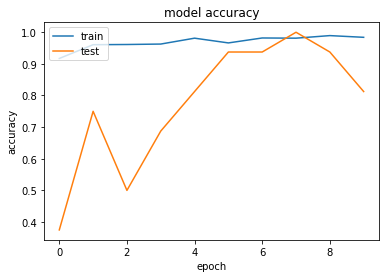

In [17]:
#visualizing the accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

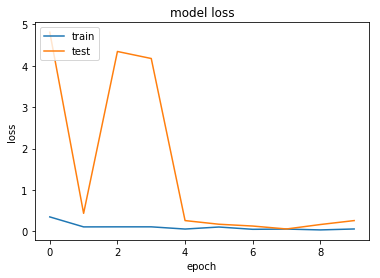

In [18]:
#visualizing the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()